# OpenAI GPTを使った要約のROUGEでの精度検証

## 使用するクラスと関数の定義

### GPT関連

In [44]:
# 所有するOpenAIのAPIキーを記述した.txtファイルのパスを指定してください
API_KEY_PATH = r"C:\Users\Issei\Documents\API Tokens\ChatGPT.txt"

In [45]:
# Function: Connect to the OpenAI API
def ConnectToOpenAI(key_path=None):
    """
    Connect to the OpenAI API
    key_path is the path to the file containing the API key (Make sure to have the API key in a .txt file and saved locally)
    """
    from openai import OpenAI
    import json
    with open(key_path, 'r') as file:
        API_KEY = file.read().rstrip()
    client = OpenAI(api_key=API_KEY)
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a program checkpoint to make sure the API is working."},
            {"role": "user", "content": "Do you see this? If so, say API is working, Hello World!"},
        ]
    )
    print(response.choices[0].message.content)
    return client

# Function: Send a doucuments to be summarized and return summarized text
def SummarizeDocument(client, document):
    """
    Summarize a document using the OpenAI API
    client: is client object from OpenAI API, use ConnectToOpenAI() to get client object
    document: is the text(str) to be summarized
    """
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system",
             "content": """
                        You are a professional summarizer. You will be given a document to summarize from the user.
                        Instruction as follows: Input and out put is in Japanese. Summarize the doucument around 100 letters. 
                        After summarize, count the number of summarized letters, if it is exceed 100 letters or less than 70 letters, summarize again.
                        Output Format: Only output the final summarized text.
                        """},
            {"role": "user", "content": document},
        ]
    )
    return response.choices[0].message.content

**ここで使用したシステムプロンプト**

You are a professional summarizer. You will be given a document to summarize from the user.

Instruction as follows: Input and out put is in Japanese. Summarize the doucument around 100 letters. After summarize, count the number of summarized letters, if it is exceed 100 letters, summarize again.

Output Format: Only output the final summarized text.

### MeCabとROUGE関連

In [46]:
import fugashi
from rouge_score.tokenizers import Tokenizer

class MeCabTokenizer(Tokenizer):
    def __init__(self, use_stemmer=False):
        self._stemmer = use_stemmer
        
        self.tagger = fugashi.Tagger()
        self.wakati = fugashi.Tagger("-Owakati")

    def tokenize(self, text):
        if self._stemmer:
            node = self.tagger.parseToNode(text)
            original_forms = []
            while node:
                feature = node.feature.split(",")
                original_forms.append(feature[6])
                node = node.next

            return original_forms
        
        else:
            return self.wakati.parse(text).split()

# Function: Calulate ROUGE score with reference
def CalculateROUGE(reference, summary):
    """
    Calculate ROUGE score with reference
    reference: is the reference summary
    summary: is the summary to be evaluated, both in str format
    """
    from rouge_score import rouge_scorer
    mecab_tokenizer = MeCabTokenizer()
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True, tokenizer=mecab_tokenizer)
    scores = scorer.score(reference, summary)
    return scores

# Plot ROUGE score
import matplotlib.pyplot as plt
import numpy as np

def PlotROUGEScore(scores):
    """
    Plot ROUGE score
    scores: is the ROUGE score in dict format
    """
    fig, ax = plt.subplots(1, 3, figsize=(13, 5))
    ax[0].bar(['Precision', 'Recall', 'fmeasure'], [scores['rouge1'].precision, scores['rouge1'].recall, scores['rouge1'].fmeasure], color=['red', 'orange', 'blue'])
    ax[0].set_title('ROUGE-1')
    ax[0].set_ylim(0, 1)
    ax[1].bar(['Precision', 'Recall', 'fmeasure'], [scores['rouge2'].precision, scores['rouge2'].recall, scores['rouge2'].fmeasure], color=['red', 'orange', 'blue'])
    ax[1].set_title('ROUGE-2')
    ax[1].set_ylim(0, 1)
    ax[2].bar(['Precision', 'Recall', 'fmeasure'], [scores['rougeL'].precision, scores['rougeL'].recall, scores['rougeL'].fmeasure], color=['red', 'orange', 'blue'])
    ax[2].set_title('ROUGE-L')
    ax[2].set_ylim(0, 1)
    return fig

In [47]:
# Function: read text file
def ReadTextFile(file_path):
    """
    Read text file
    file_path: is the path to the text file
    """
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

## 10個の要約データから平均ROUGEスコアを計算

In [48]:
# For loop to summarize multiple documents
client = ConnectToOpenAI(API_KEY_PATH)

# summed ROUGE score in rouge_score format
summed_ROUGE = {
'rouge1': {'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0},
'rouge2': {'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0},
'rougeL': {'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0}
}

for i in range(0, 10):
    # Read document and reference
    document_path = "Data/doc/doc-" + str(i) + ".txt"
    ref_path = "Data/ref/ref-" + str(i) + ".txt"
    document = ReadTextFile(document_path)
    reference = ReadTextFile(ref_path)

    # Suumarize document
    summary = SummarizeDocument(client, document)
    print(i, summary) # Check the summary

    # Calculate ROUGE score
    scores = CalculateROUGE(reference, summary)
    print(scores)

    # Save ROUGE score plot
    plot = PlotROUGEScore(scores)
    plot.savefig("Data/plot/plot-" + str(i) + ".png")
    plt.close()

    # Save summary
    with open("Data/sum/sum-" + str(i) + ".txt", 'w') as file:
        file.write(summary)
    print("Done with", i)

    # sum up ROUGE scores for each document
    summed_ROUGE['rouge1']['precision'] += scores['rouge1'].precision
    summed_ROUGE['rouge1']['recall'] += scores['rouge1'].recall
    summed_ROUGE['rouge1']['fmeasure'] += scores['rouge1'].fmeasure
    summed_ROUGE['rouge2']['precision'] += scores['rouge2'].precision
    summed_ROUGE['rouge2']['recall'] += scores['rouge2'].recall
    summed_ROUGE['rouge2']['fmeasure'] += scores['rouge2'].fmeasure
    summed_ROUGE['rougeL']['precision'] += scores['rougeL'].precision
    summed_ROUGE['rougeL']['recall'] += scores['rougeL'].recall
    summed_ROUGE['rougeL']['fmeasure'] += scores['rougeL'].fmeasure
print("All done!")

API is working, Hello World!
0 現代日本には「文化的貧困」が問題視されており、これは経済的困窮だけでなく、心や感性の貧困を意味する。絶対的貧困や相対的貧困でないが、文化的に豊かさを感じられないとする状況で、例えば「コンビニ弁当しか食べられない」のもその一例である。憲法第25条が示す「健康で文化的な最低限度の生活」は、文化の貧しさゆえに成立しない可能性があると指摘されている。
{'rouge1': Score(precision=0.45689655172413796, recall=0.7910447761194029, fmeasure=0.5792349726775956), 'rouge2': Score(precision=0.26956521739130435, recall=0.4696969696969697, fmeasure=0.3425414364640884), 'rougeL': Score(precision=0.3017241379310345, recall=0.5223880597014925, fmeasure=0.3825136612021858)}
Done with 0
1 英語は世界共通語としての利便性がありますが、「英語帝国主義」としての問題も存在します。日本語には英語で表現しにくい概念や言葉が多く、説明に困ることがあります。例えば、日本の「家」は英語の「family」とは異なる意味を持ち、特定の日本文化を表す言葉も同様です。これは単なる表現の問題ではなく、英語が知識を支配する問題と言えます。
{'rouge1': Score(precision=0.3490566037735849, recall=0.6271186440677966, fmeasure=0.4484848484848485), 'rouge2': Score(precision=0.14285714285714285, recall=0.25862068965517243, fmeasure=0.18404907975460125), 'rougeL': Score(precision=0.2358490566037736, recall=0.423728813559322, fmeasure=0.303030303030

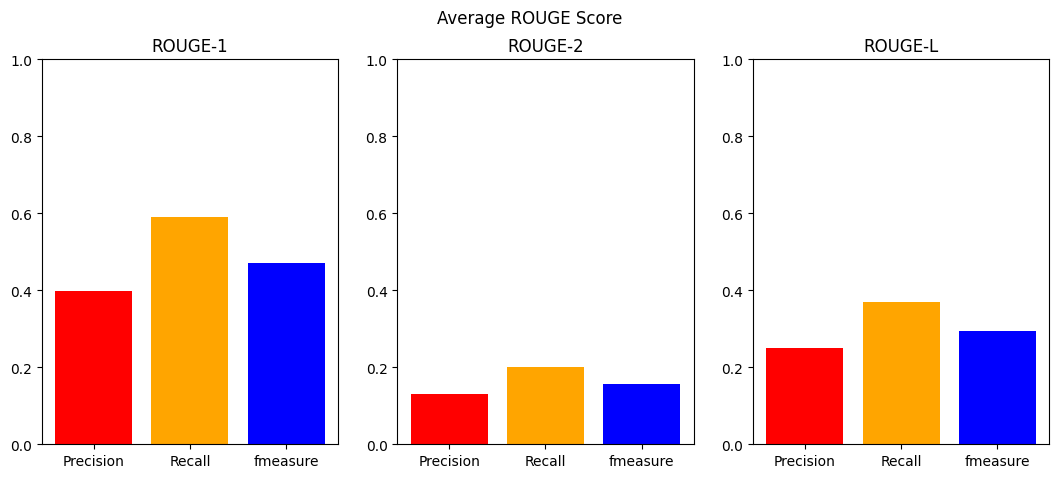

In [49]:
# Plot summed ROUGE score
# Calculate average ROUGE score (n=10)
summed_ROUGE['rouge1']['precision'] /= 10
summed_ROUGE['rouge1']['recall'] /= 10
summed_ROUGE['rouge1']['fmeasure'] /= 10
summed_ROUGE['rouge2']['precision'] /= 10
summed_ROUGE['rouge2']['recall'] /= 10
summed_ROUGE['rouge2']['fmeasure'] /= 10
summed_ROUGE['rougeL']['precision'] /= 10
summed_ROUGE['rougeL']['recall'] /= 10
summed_ROUGE['rougeL']['fmeasure'] /= 10

# Plot summed ROUGE score in dict format
fig, ax = plt.subplots(1, 3, figsize=(13, 5))
ax[0].bar(['Precision', 'Recall', 'fmeasure'], [summed_ROUGE['rouge1']['precision'], summed_ROUGE['rouge1']['recall'], summed_ROUGE['rouge1']['fmeasure']], color=['red', 'orange', 'blue'])
ax[0].set_title('ROUGE-1')
ax[0].set_ylim(0, 1)
ax[1].bar(['Precision', 'Recall', 'fmeasure'], [summed_ROUGE['rouge2']['precision'], summed_ROUGE['rouge2']['recall'], summed_ROUGE['rouge2']['fmeasure']], color=['red', 'orange', 'blue'])
ax[1].set_title('ROUGE-2')
ax[1].set_ylim(0, 1)
ax[2].bar(['Precision', 'Recall', 'fmeasure'], [summed_ROUGE['rougeL']['precision'], summed_ROUGE['rougeL']['recall'], summed_ROUGE['rougeL']['fmeasure']], color=['red', 'orange', 'blue'])
ax[2].set_title('ROUGE-L')
ax[2].set_ylim(0, 1)
fig.suptitle("Average ROUGE Score")
fig.savefig("Data/plot/plot-sum.png")